In [1]:
#Dev

import pandas as pd
import numpy as np
import seaborn as sns
from mysql.connector import MySQLConnection, Error
from XML2MySQL import connect
from MySQL2PandasDF import MySQL2PandasDF
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
% matplotlib inline

# Init Session Object

In [2]:
password = 'F0xyrules30'

In [3]:
session = MySQL2PandasDF(host = 'localhost', db = 'stackexchange_travel', user = 'root', password = password)

Connection to MySQL database stackexchange_travel successful.


## db2df method parses the entirety of a database to dict of pandas dfs

In [4]:
session.db2df()

C:\Users\jeffe\Anaconda3\lib\site-packages\sqlalchemy\dialects\mysql\base.py:1546: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  cursor.execute('SELECT @@tx_isolation')


Underlying structure is a dictionary with the following format:

{Table Name: df}

In [5]:
# tables in our dictionary

session.source.keys()

dict_keys(['badges', 'comments', 'posthistory', 'postlinks', 'posts', 'tags', 'users', 'votes'])

## Head of posts table

In [6]:
session.source['posts'].head()

,index,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,0,393,4,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaT,2011-06-21T20:19:34.730,NaN,1,...,None,101.0,None,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,419.0
1,1,None,7,"<p>This was one of our definition questions, b...",None,4,NaT,2011-06-21T20:22:33.760,5.0,2,...,None,13.0,None,13.0,NaN,1,32,<guides><extreme-tourism><amazon-river><amazon...,How can I find a guide that will take me safel...,1399.0
2,2,None,None,<p>One way would be to go through an Adventure...,None,2,NaT,2011-06-21T20:24:28.080,NaN,3,...,None,NaN,None,9.0,2.0,2,12,None,None,NaN
3,3,None,1,<p>Singapore Airlines has an all-business clas...,None,1,NaT,2011-06-21T20:24:57.160,NaN,4,...,None,693.0,None,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,243.0
4,4,770,5,<p>Another definition question that interested...,None,0,NaT,2011-06-21T20:25:56.787,2.0,5,...,None,101.0,None,13.0,NaN,1,14,<romania><transportation>,What is the easiest transportation to use thro...,395.0


## Parse columns with html present

In [7]:
session.parse_html('posts','Body')

In [ ]:
session.source['posts']['Body'].head()

## Extract tags from < >

In [9]:
import string
def extract_tags_from_aligators(input_str_pandas_Series):
    
    """
    
    This function extracts strings from the depths of two alligators' teeth <tag> in a pandas Series
    New pandas Series 'Text_Search_Space' will be returned
    
    :params:     input_str_pandas_Series:              pandas.core.series.Series
                
    :return:     text_search_space_pandas_Series:      pandas.core.series.Series
    
    """
    return input_str_pandas_Series.str.findall(r"<(:?.+)>").str.join('').str.replace('>','').str.replace('<',' ').str.replace(r"[^\w\s]", ' ').str.lower()

In [10]:
session.source['posts']['Tags_tags_removed'] = extract_tags_from_aligators(session.source['posts']['Tags'])
session.source['posts']['Tags_tags_removed'][0]

'caribbean cruising vacations'

## Create new search space feature

In [11]:
def make_str_fill_in_nans_pandas_Series(input_str_pandas_Series, nan_filler = ''):
    
    """
    
    This function fills nans in a pandas Series with an optional filler
    Input pandas Series will be returned with nans filled
    
    :params:     input_str_pandas_Series:                pandas.core.series.Series
                 nan_filler:                             str
                
    :return:     input_str_pandas_Series_nans_filled:    pandas.core.series.Series
    
    """
    
    assert str(type(input_str_pandas_Series)) == "<class 'pandas.core.series.Series'>"
    assert str(type(nan_filler)) == "<class 'str'>"
    
    return input_str_pandas_Series.fillna(nan_filler).map(str)

def create_search_space(seperator, lower_case, input_str_pandas_Series1, input_str_pandas_Series2, *args):
    
    """
    
    This function concats pandas Series together with an optional seperator
    A minimum of two pandas Series must be provided
    Additional pandas_Series up to 5 can be used as inputs
    New pandas Series 'Text_Search_Space' will be returned
    
    
    :params:     seperator:                              str
                 lower_case:                             Boolean
                 input_str_pandas_Series1:               pandas.core.series.Series
                 input_str_pandas_Series2:               pandas.core.series.Series
                 input_str_pandas_Series_n:              pandas.core.series.Series
                
    :return:     text_search_space_pandas_Series:        pandas.core.series.Series
    
    """
    text_search_space_pandas_Series = pd.Series()
    
    assert str(type(input_str_pandas_Series1)) == "<class 'pandas.core.series.Series'>" and str(type(input_str_pandas_Series2)) == "<class 'pandas.core.series.Series'>"
    assert str(type(seperator)) == "<class 'str'>"
    assert str(type(lower_case)) == "<class 'bool'>"
    
    if lower_case is True: 
        text_search_space_pandas_Series = pd.Series(make_str_fill_in_nans_pandas_Series(input_str_pandas_Series1).str.lower().values \
                                                + seperator + make_str_fill_in_nans_pandas_Series(input_str_pandas_Series2).str.lower().values)
    else:
        text_search_space_pandas_Series = pd.Series(make_str_fill_in_nans_pandas_Series(input_str_pandas_Series1).values \
                                                + seperator + make_str_fill_in_nans_pandas_Series(input_str_pandas_Series2).values)
    
    for input_pandas_series_n in [i for i in args if str(type(i)) == "<class 'pandas.core.series.Series'>"]:
        if lower_case is True:
            text_search_space_pandas_Series = pd.Series(text_search_space_pandas_Series.values + seperator + make_str_fill_in_nans_pandas_Series(input_pandas_series_n).str.lower().values)
        else:
            text_search_space_pandas_Series = pd.Series(text_search_space_pandas_Series.values + seperator + make_str_fill_in_nans_pandas_Series(input_pandas_series_n).values)
    
    return text_search_space_pandas_Series

In [12]:
session.source['posts']['Search_Space'] = create_search_space(' ', True, session.source['posts']['Tags_tags_removed'], session.source['posts']['Title'], session.source['posts']['Body'])
print("".join(session.source['posts']['Search_Space'].head()[0]))

caribbean cruising vacations what are some caribbean cruises for october? my fiancée and i are looking for a good caribbean cruise in october and were wondering which islands are best to see and which cruise line to take? it seems like a lot of the cruises don't run in this month due to hurricane season so i'm looking for other good options. edit we'll be travelling in 2012. 


# Remove stopwords

In [13]:
from nltk.corpus import stopwords
import string
stop = stopwords.words('english')

def remove_stop_words(text):
    
    '''
    
    This function takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    
    :params:   text:    str
    :return:   text:    str
    
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return ' '.join([word for word in nopunc.split() if word.lower() not in stop])

In [14]:
session.source['posts']['Search_Space_stopwords_removed'] = session.source['posts']['Search_Space'].apply(lambda x: remove_stop_words(x))
print(session.source['posts']['Search_Space_stopwords_removed'][0])

caribbean cruising vacations caribbean cruises october fiancée looking good caribbean cruise october wondering islands best see cruise line take seems like lot cruises dont run month due hurricane season im looking good options edit well travelling 2012


## Make lemmanade out of the lemmas

In [15]:
def lemma(text):
    
    '''
    
    Takes in a string of text, then performs the following:
    1. Reduce all words down to lemma (root word)
    2. Return lemmatized words
    
    :params:   text:   str
    :return:   text:   str
    
    '''
    from nltk.stem.wordnet import WordNetLemmatizer
    lemma = WordNetLemmatizer()
    normalized = " ".join(lemma.lemmatize(word,'v') for word in text.split())
    x = normalized.split()
    y = [s for s in x if len(s) > 2]
    return y

In [16]:
session.source['posts']['Search_Space_stopwords_removed_lemma'] = session.source['posts']['Search_Space_stopwords_removed'].apply(lambda x: lemma(x))
print(" ".join(session.source['posts']['Search_Space_stopwords_removed_lemma'][0]))

caribbean cruise vacation caribbean cruise october fiancée look good caribbean cruise october wonder islands best see cruise line take seem like lot cruise dont run month due hurricane season look good options edit well travel 2012


## Build Dictionary to Feed to LDA Model

In [17]:
from gensim import corpora
list_of_post_contents = list()
for post_contents in session.source['posts']['Search_Space_stopwords_removed_lemma']:
    list_of_post_contents.append(post_contents)

dictionary = corpora.Dictionary(list_of_post_contents)

# Filter terms which occurs in less than 4 articles & more than 50% of the articles 
dictionary.filter_extremes(no_below=4, no_above=0.5)

# List of few words which are removed from dictionary as they are content neutral
stoplist = set('also use make people know many call include part find become like mean often different \
               usually take wikt come give well get since type list say change see refer actually iii \
               aisne kinds pas ask would way something need things want every str one piece two dont put try sure \
               even ive might really shall may must youre'.split())
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in list_of_post_contents]

C:\Users\jeffe\Anaconda3\lib\site-packages\gensim-3.2.0-py3.6-win-amd64.egg\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Build LDA Model (Top 30 Topics)

In [18]:
from gensim.models.ldamodel import LdaModel as Lda
# Creating the object for LDA model using gensim library & Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=30, id2word = dictionary, passes=50, iterations=500)

# Print all the 30 topics
for i,topic in enumerate(ldamodel.print_topics(num_topics=30, num_words=10)):
    words = topic[1].split("+")
    print(words,"\n")

['0.161*"india" ', ' 0.046*"singapore" ', ' 0.044*"thailand" ', ' 0.041*"turkey" ', ' 0.026*"asia" ', ' 0.025*"vietnam" ', ' 0.025*"istanbul" ', ' 0.024*"delhi" ', ' 0.023*"malaysia" ', ' 0.021*"philippines"'] 

['0.142*"flight" ', ' 0.043*"airlines" ', ' 0.040*"fly" ', ' 0.040*"airline" ', ' 0.036*"air" ', ' 0.028*"travel" ', ' 0.023*"board" ', ' 0.015*"passengers" ', ' 0.015*"delay" ', ' 0.013*"layover"'] 

['0.089*"car" ', ' 0.064*"drive" ', ' 0.042*"insurance" ', ' 0.034*"company" ', ' 0.030*"rent" ', ' 0.027*"rental" ', ' 0.023*"drivers" ', ' 0.021*"tip" ', ' 0.018*"cover" ', ' 0.015*"vehicle"'] 

['0.034*"prior" ', ' 0.033*"italy" ', ' 0.030*"attend" ', ' 0.030*"image" ', ' 0.029*"conference" ', ' 0.026*"wear" ', ' 0.022*"group" ', ' 0.021*"rome" ', ' 0.017*"action" ', ' 0.017*"white"'] 

['0.184*"train" ', ' 0.057*"station" ', ' 0.033*"london" ', ' 0.028*"germany" ', ' 0.022*"travel" ', ' 0.017*"rail" ', ' 0.014*"journey" ', ' 0.012*"zone" ', ' 0.011*"berlin" ', ' 0.011*"german"

In [ ]:
import re
topics = list()
for i,topic in enumerate(ldamodel.print_topics(num_topics=30, num_words=10)):
    rankings = dict()
    words = topic[1].split("+")
    topics.append()
    rankings[] = re.findall('((.*)\*\"(.*)\")', words)
    print(words,"\n")

## Visualizing intertopic relationships (PCA)

In [19]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(lda_vis, 'lda.html')
pyLDAvis.save_json(lda_vis, 'lda.json')
pyLDAvis.display(lda_vis)

C:\Users\jeffe\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


## Plot Top 30 Words Pareto (PCA)

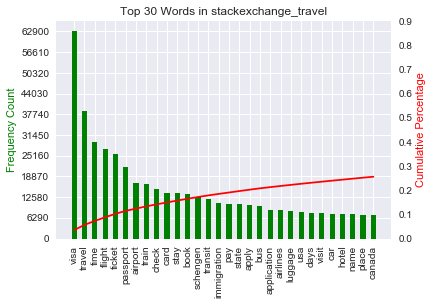

In [25]:
import json
from collections import defaultdict
import numpy as np

with open('lda.json') as json_data:
    d = json.load(json_data)
    topic_rankings_default = defaultdict(list)
    
    for topic, freq in zip(d['tinfo']['Term'], d['tinfo']['Freq']):
        topic_rankings_default[topic].append(freq)

most_occuring_words_dict = dict()
most_occuring_words_list = list()

for topic in topic_rankings_default.keys():
    most_occuring_words_dict[topic] = topic_rankings_default[topic][0]
    
for topic in sorted(most_occuring_words_dict.items(), key=lambda x: x[1], reverse=True):
    most_occuring_words_list.append(topic)
    
top_n_topics, top_n_term_frequency = zip(*most_occuring_words_list[:30])
all_topics, total_term_frequency = zip(*most_occuring_words_list)

term_frequency_pareto_line = list()
cumulative_percent = float()
for term_freq in top_n_term_frequency:
    cumulative_percent += term_freq/sum(total_term_frequency)
    term_frequency_pareto_line.append(cumulative_percent)

xs = np.arange(len(top_n_topics)) 
width = 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

bar = ax1.bar(xs, top_n_term_frequency, width*0.5, color='g', align='center')

line = ax2.plot(xs, term_frequency_pareto_line, 'r-')

ax1.set_ylabel('Frequency Count', color='g')
ax1.set_xticks(xs) #Replace default x-ticks with xs, then replace xs with labels
ax1.set_xticklabels(top_n_topics, rotation=90) #Replace default x-ticks with xs, then replace xs with labels
ax1.set_yticks([tick for tick in range(0, int(max(top_n_term_frequency)), int(max(top_n_term_frequency))//10)])

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(False)
ax2.set_ylabel('Cumulative Percentage', color='r')
ax2.set_yticks([tick for tick in np.arange(0,1,0.1)])
plt.title('Top 30 Words in {}'.format(session.db))

plt.show()
# plt.savefig('netscore.png')

## Visualizing intertopic relationships (tsne)

In [20]:
tsne_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds='tsne')
pyLDAvis.save_html(tsne_vis, 'tsne.html')
pyLDAvis.save_json(tsne_vis, 'tsne.json')
pyLDAvis.display(tsne_vis)

C:\Users\jeffe\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


## Plot Top 30 Words Pareto (tsne)

In [ ]:
import json
from collections import defaultdict
import numpy as np

with open('tsne.json') as json_data:
    d = json.load(json_data)
    topic_rankings_default = defaultdict(list)
    
    for topic, freq in zip(d['tinfo']['Term'], d['tinfo']['Freq']):
        topic_rankings_default[topic].append(freq)

most_occuring_words_dict = dict()
most_occuring_words_list = list()

for topic in topic_rankings_default.keys():
    most_occuring_words_dict[topic] = topic_rankings_default[topic][0]
    
for topic in sorted(most_occuring_words_dict.items(), key=lambda x: x[1], reverse=True):
    most_occuring_words_list.append(topic)
    
top_n_topics, top_n_term_frequency = zip(*most_occuring_words_list[:30])
all_topics, total_term_frequency = zip(*most_occuring_words_list)

term_frequency_pareto_line = list()
cumulative_percent = float()
for term_freq in top_n_term_frequency:
    cumulative_percent += term_freq/sum(total_term_frequency)
    term_frequency_pareto_line.append(cumulative_percent)

xs = np.arange(len(top_n_topics)) 
width = 1

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

bar = ax1.bar(xs, top_n_term_frequency, width*0.5, color='g', align='center')

line = ax2.plot(xs, term_frequency_pareto_line, 'r-')

ax1.set_ylabel('Frequency Count', color='g')
ax1.set_xticks(xs) #Replace default x-ticks with xs, then replace xs with labels
ax1.set_xticklabels(top_n_topics, rotation=90) #Replace default x-ticks with xs, then replace xs with labels
ax1.set_yticks([tick for tick in range(0, int(max(top_n_term_frequency)), int(max(top_n_term_frequency))//10)])

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.grid(False)
ax2.set_ylabel('Cumulative Percentage', color='r')
ax2.set_yticks([tick for tick in np.arange(0,1,0.1)])
plt.title('Top 30 Words in {}'.format(session.db))

plt.show()
# plt.savefig('netscore.png')

# Commentary

* #### 30 Topics appears to be too many to see any significant overlap between topics
* #### The tsne view of the data highlights the need to reduce the number of topics our LDA model is splitting the data into
    * #### The overlaps observed seem to go very nicely together when they do occur (tickets, flight, book & visa, passport)

Lets build an LDA model with [10, 5] topics and build the same tsne and PCA visulaizations of the intertopic relationships

## Build LDA Model (Top 10 Topics)

##### PCA View

In [ ]:
num_topics = 10

# Creating the object for LDA model using gensim library & Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50, iterations=500)

lda_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(lda_vis)

##### tsne view

In [ ]:
tsne_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds='tsne')
pyLDAvis.display(tsne_vis)

# save files
pyLDAvis.save_html(lda_vis, 'lda_{}.html'.format(str(num_topics)))
pyLDAvis.save_html(tsne_vis, 'tsne_{}.html'.format(str(num_topics)))

## Build LDA Model (Top 5 Topics)

##### PCA View

In [ ]:
num_topics = 5

# Creating the object for LDA model using gensim library & Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50, iterations=500)

lda_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(lda_vis)

##### tsne view

In [ ]:
tsne_vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds='tsne')
pyLDAvis.display(tsne_vis)

# save files
pyLDAvis.save_html(lda_vis, 'lda_{}.html'.format(str(num_topics)))
pyLDAvis.save_html(tsne_vis, 'tsne_{}.html'.format(str(num_topics)))